In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ehtim as eh

import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from utils import NeuralImage, train_step, train_step_hetero


Welcome to eht-imaging! v 1.2.10 



Loading text image:  datasets/avery_sgra_eofn.txt


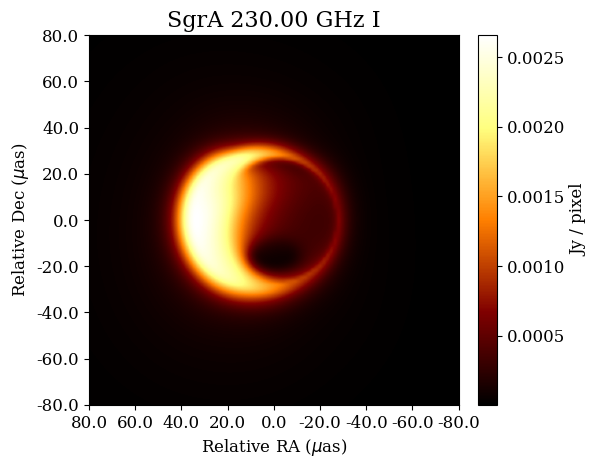

In [2]:
image_path = 'datasets/avery_sgra_eofn.txt'
array_path = 'datasets/EHT2017.txt'
image_true = eh.image.load_txt(image_path)
array = eh.array.load_txt(array_path)
image_true.display()

intensity_gt = jnp.array(image_true.imarr(), dtype=jnp.float32)
ydim, xdim = intensity_gt.shape
assert intensity_gt.size == image_true.imvec.size

x, y = np.linspace(0, 1, xdim), np.linspace(0, 1, ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='xy')), 0, -1)

coords_flat = coords.reshape(-1,2)
gt_flat = intensity_gt.ravel()

In [3]:
mask = coords_flat[:, 0] > 0.5
coords_train = coords_flat[~mask]
Y_train_true = gt_flat[~mask] # no noise applied

coords_test = coords_flat[mask]
Y_test_true = gt_flat[mask] #no noise applied

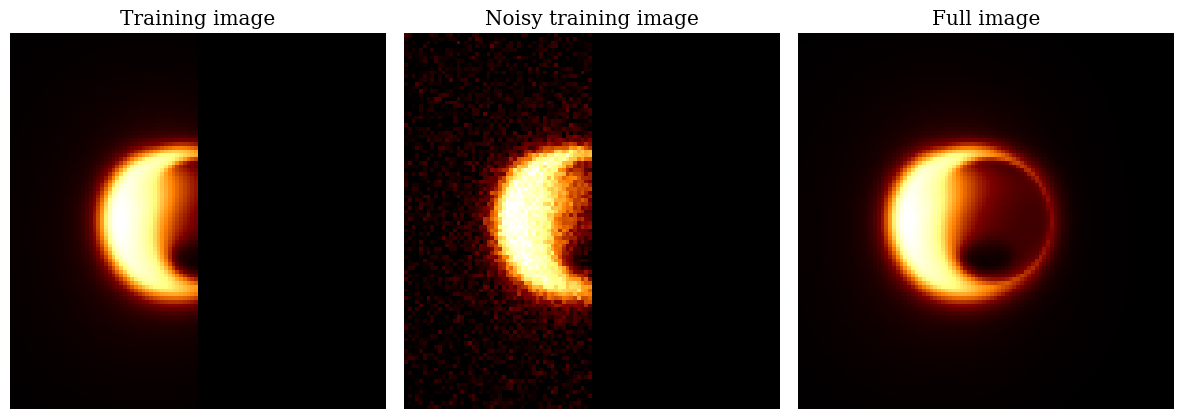

In [4]:
rng = jax.random.PRNGKey(42)
noise = 0.05 * jnp.max(jnp.abs(Y_train_true))

#add gaussian noise
Y_train = Y_train_true + noise * jax.random.normal(rng, Y_train_true.shape)
sigma_vec = jnp.full_like(Y_train, noise)

# plot
full_clean = jnp.zeros(xdim*ydim)
full_noisy = jnp.zeros(xdim*ydim)

full_clean = full_clean.at[~mask].set(Y_train_true)
full_noisy = full_noisy.at[~mask].set(Y_train)

I_clean = full_clean.reshape(ydim, xdim)
I_noisy = full_noisy.reshape(ydim, xdim)

vmin, vmax = float(I_clean.min()), float(I_clean.max())
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(I_clean, cmap='afmhot', vmin=vmin, vmax=vmax, origin='upper')
ax[0].set_title("Training image")
ax[1].imshow(I_noisy, cmap='afmhot', vmin=vmin, vmax=vmax, origin='upper')
ax[1].set_title("Noisy training image")
ax[2].imshow(intensity_gt, cmap='afmhot')
ax[2].set_title("Full image")

for a in ax: 
    a.axis('off')
plt.tight_layout()
plt.show()

In [5]:
predictor = NeuralImage(posenc_deg=3, net_depth=4, net_width=128, activation=nn.relu, out_channel=1, do_skip=True)

hparams = {'num_iters': 10000, 'lr_init': 1e-3, 'lr_final': 1e-4, 'batchsize': 1000}

params = predictor.init(rng, coords)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)

for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    batch = np.random.choice(range(len(coords_train)), hparams['batchsize'], replace=False)
    loss, state, image = train_step(state, Y_train[batch], coords_train[batch])
    if i % 1000 == 0:
        print(f"iteration {i}, loss={loss:.5f}")


iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

iteration 0, loss=0.58522
iteration 1000, loss=0.00000
iteration 2000, loss=0.00000
iteration 3000, loss=0.00000
iteration 4000, loss=0.00000
iteration 5000, loss=0.00000
iteration 6000, loss=0.00000
iteration 7000, loss=0.00000
iteration 8000, loss=0.00000
iteration 9000, loss=0.00000


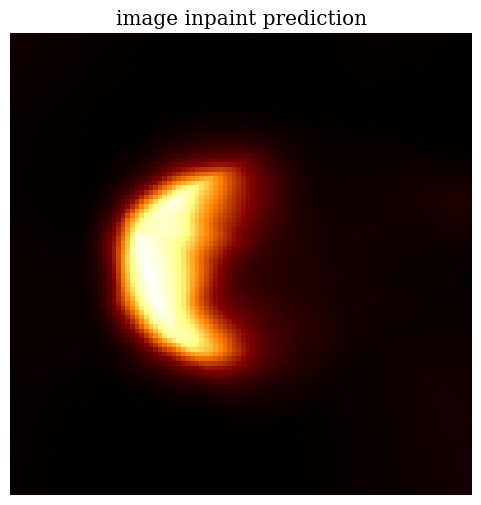

In [6]:
full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)
plt.figure(figsize=(6,6))
plt.imshow(full_image, cmap='afmhot', origin='upper')
plt.axis('off')
plt.title('image inpaint prediction')
plt.show()

In [7]:
def bilinear(coords, theta):
    """gpt generated function to fill in for now"""
    gx, gy, _ = theta.shape
    # scale to vertex index space
    x = coords[..., 0] * (gx - 1)
    y = coords[..., 1] * (gy - 1)

    i0 = jnp.floor(x).astype(jnp.int32)
    j0 = jnp.floor(y).astype(jnp.int32)
    i1 = jnp.clip(i0 + 1, 0, gx - 1)
    j1 = jnp.clip(j0 + 1, 0, gy - 1)

    wx = x - i0
    wy = y - j0

    # gather four corners
    t00 = theta[i0, j0]      # lower-left
    t10 = theta[i1, j0]      # lower-right
    t01 = theta[i0, j1]      # upper-left
    t11 = theta[i1, j1]      # upper-right

    return ((1 - wx) * (1 - wy))[..., None] * t00 + \
           (     wx  * (1 - wy))[..., None] * t10 + \
           ((1 - wx) *      wy )[..., None] * t01 + \
           (     wx  *      wy )[..., None] * t11

class DeformationGrid(nn.Module):
    resolution: tuple[int, ...]

    @nn.compact
    def __call__(self, coords):
        theta = self.param(
            'theta', 
            nn.initializers.zeros, 
            self.resolution + (coords.shape[-1],)
        )
        return bilinear(coords, theta)

def forward_with_deform(params_img, params_def, coords):
    offsets = DeformationGrid.apply({'params': params_def}, coords)
    return predictor.apply({'params': params_img}, coords + offsets)

grid_res = (72, 72)
def_grid = DeformationGrid(grid_res)

In [8]:
"""prepare variables for bayes rays"""
npix = ydim
params_def = def_grid.init(
    jax.random.PRNGKey(0),
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)

params_img = state.params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

$$I(\theta) = \frac{4}{\sigma^2} \sum_n J^TJ

In [9]:
#implement bayes rays
def forward_offset(params_def, coords):
    """
    add offset and get updated visibility matrix
    """
    offsets = def_grid.apply({'params': params_def}, coords)
    img_pred = predictor.apply({'params': params_img_frozen}, coords + offsets)
    return img_pred

def f_scalar(params_def, coord):
    return forward_offset(params_def, coord[None, :])[0]

def grad_row(params_def, coord):
    g_tree = jax.grad(f_scalar)(params_def, coord)
    return g_tree['theta']

@jax.jit
def chunk(params_def, coords_batch):
    jacobian = jax.vmap(grad_row, in_axes=(None, 0))(params_def, coords_batch)
    return jnp.sum(jacobian**2, axis=0) 

def fisher_sum(chunk_size, res):
    """
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    J_sq = jnp.zeros((res[0], res[1], 2))
    nvis = coords_train.shape[0]
    for start in range(0, nvis, chunk_size):
        end = min(start + chunk_size, nvis)
        J_sq += chunk(params_def, coords_train[start:end])
    return J_sq

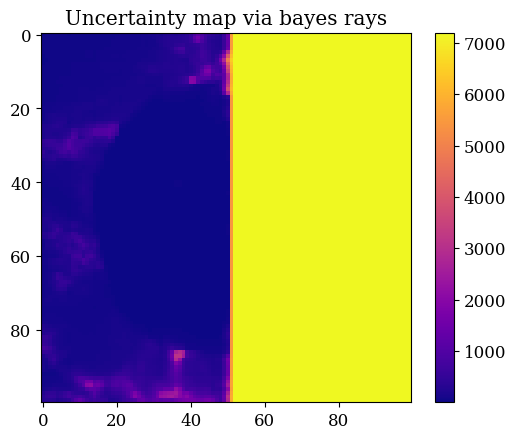

In [10]:
chunk_size = 8
J_sq = fisher_sum(chunk_size, grid_res)

lam = 1e-4 / (grid_res[0]*grid_res[1])
H_diag = (4/noise**2)*(J_sq/coords_flat.shape[0]) + 2.0 * lam # deterministic H, no monte carlo
variance_grid = 1 / H_diag
sigma_map = jnp.linalg.norm(
    jnp.sqrt(bilinear(coords, variance_grid)), 
    axis=-1
)

plt.figure()
plt.imshow(sigma_map, cmap='plasma')
plt.title("Uncertainty map via bayes rays")
plt.colorbar()
plt.show()

5e-05
5.4500448e-05
5.90009e-05
6.350135e-05
6.80018e-05
7.250225e-05
7.70027e-05
8.150315e-05
8.6003594e-05
9.050405e-05
9.500451e-05
9.9504956e-05
0.000104005405
0.000108505854
0.0001130063
0.00011750676
0.0001220072
0.00012650766
0.0001310081
0.00013550856
0.00014000901
0.00014450945
0.00014900991
0.00015351035
0.00015801081
0.00016251125
0.0001670117
0.00017151216
0.0001760126
0.00018051305
0.00018501352
0.00018951396
0.0001940144
0.00019851486
0.00020301531
0.00020751577
0.0002120162
0.00021651665
0.00022101711
0.00022551756
0.00023001802
0.00023451846
0.0002390189
0.00024351936
0.00024801982
0.00025252026
0.0002570207
0.00026152117
0.0002660216
0.00027052205
0.00027502252
0.00027952297
0.0002840234
0.00028852388
0.00029302432
0.00029752476
0.0003020252
0.00030652565
0.00031102612
0.00031552656
0.00032002703
0.00032452747
0.00032902794
0.00033352838
0.0003380288
0.00034252927
0.0003470297
0.00035153018
0.00035603062
0.00036053106
0.00036503153
0.00036953198
0.00037403242
0.0003785

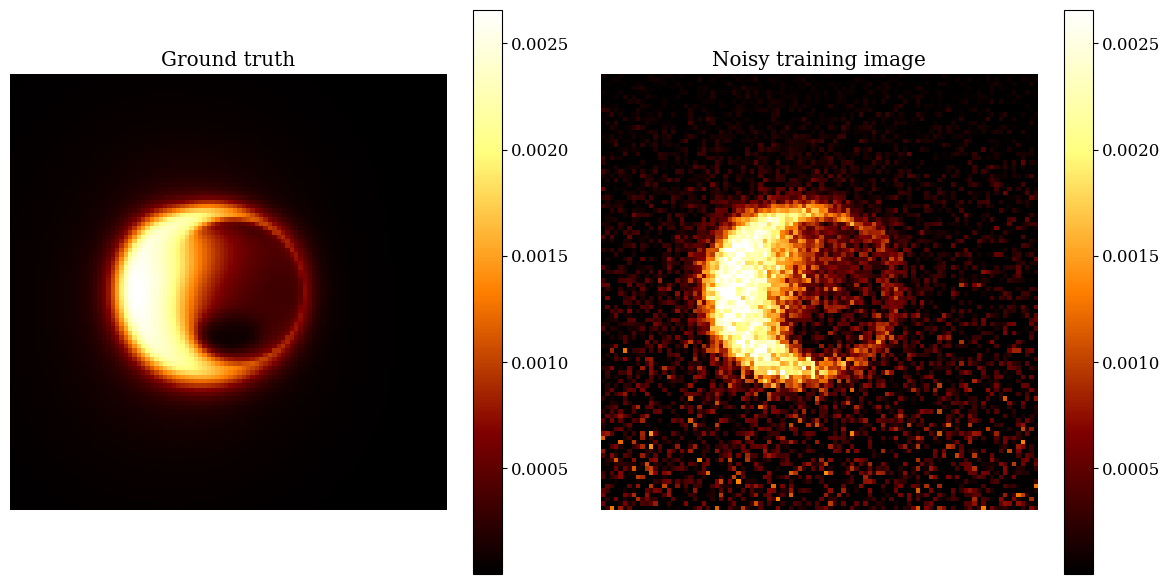

In [ ]:
# bayes rays with heteroskedastic noise
ydim, xdim = intensity_gt.shape
band_edges = [0, 20, 40, 60, 80, ydim]
sigma_mat = jnp.zeros_like(intensity_gt)
sigmas = [1e-4, 3e-4, 6e-4, 1e-3, 3e-3]
for i in range(len(sigmas)):
    top, bottom = band_edges[i], band_edges[i+1]
    sigma_mat = sigma_mat.at[top:bottom, :].set(sigmas[i])

sigma_vec = sigma_mat.ravel()
rng = jax.random.PRNGKey(0)
#sigma_vec = jnp.linspace(0.00005, 0.0005, gt_flat.shape[0])
coords_train = coords_flat
Y_train_true = gt_flat
Y_train = Y_train_true + sigma_vec*jax.random.normal(rng, Y_train_true.shape) #add pixel-wise gaussian noise
# visualize and plot
vmin, vmax = float(Y_train_true.min()), float(Y_train_true.max())
fig, ax = plt.subplots(1, 2, figsize=(12,6))
im_0 = ax[0].imshow(Y_train_true.reshape(ydim, xdim), vmax=vmax, vmin=vmin, cmap='afmhot', origin='upper')
ax[0].set_title("Ground truth")
im_1 = ax[1].imshow(Y_train.reshape(ydim, xdim), vmin=vmin, vmax=vmax, cmap='afmhot', origin='upper')
ax[1].set_title("Noisy training image")
ax[0].axis('off')
ax[1].axis('off')
fig.colorbar(im_0, ax=ax[0])
fig.colorbar(im_1, ax=ax[1])
plt.tight_layout()
plt.show()

In [39]:
predictor = NeuralImage(posenc_deg=3, net_depth=5, net_width=128, activation=nn.relu, out_channel=1, do_skip=True)

hparams = {'num_iters': 9000, 'lr_init': 1e-3, 'lr_final': 1e-5, 'batchsize': 4096}

params = predictor.init(rng, coords)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)

for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    batch = np.random.choice(range(len(coords_train)), hparams['batchsize'], replace=False)
    loss, state, image = train_step_hetero(state, Y_train[batch], coords_train[batch], sigma_vec[batch]) #or just train_step(...,coords_train[batch])
    if i % 1000 == 0:
        print(f"iteration {i}, loss={float(loss):.9f}")


iteration:   0%|          | 0/9000 [00:00<?, ?it/s]

iteration 0, loss=12824974.000000000
iteration 1000, loss=1.062925100
iteration 2000, loss=1.041661382
iteration 3000, loss=1.026374936
iteration 4000, loss=1.043147326
iteration 5000, loss=1.002489328
iteration 6000, loss=1.031872153
iteration 7000, loss=1.009459734
iteration 8000, loss=1.035690308


In [40]:
"""prepare variables for bayes rays"""
def_grid = DeformationGrid(grid_res)
npix = ydim
params_def = def_grid.init(
    jax.random.PRNGKey(0),
    jnp.array([[0, 0]]))['params']
params_def = jax.tree_util.tree_map(jnp.zeros_like, params_def)

params_img = state.params
params_img_frozen = jax.tree_util.tree_map(jnp.array, params_img)

In [41]:


@jax.jit
def chunk_hetero(params_def, coords_batch, sigma_batch):
    jacobian = jax.vmap(grad_row, in_axes=(None, 0))(params_def, coords_batch)
    sigma_reshaped = sigma_batch.reshape((sigma_batch.shape[0],) + (1,) * (jacobian.ndim-1))
    jacobian_scaled = jacobian / sigma_reshaped
    return jnp.sum(jacobian_scaled**2, axis=0) 

def fisher_sum_hetero(chunk_size, res):
    """
    Args:
        chunk_size: number of rows of the jacobian to evaluate in one step
        res: grid resolution, (xdim, ydim); 2D for now
    Returns:
        J_sq: = sum( (J_re_n^2 + J_im_n^2) / sigma_n^2)
    """
    J_sq = jnp.zeros((res[0], res[1], 2))
    nvis = coords_train.shape[0]
    for start in range(0, nvis, chunk_size):
        end = min(start + chunk_size, nvis)
        J_sq += chunk_hetero(params_def, coords_train[start:end], sigma_vec[start:end])
    return J_sq

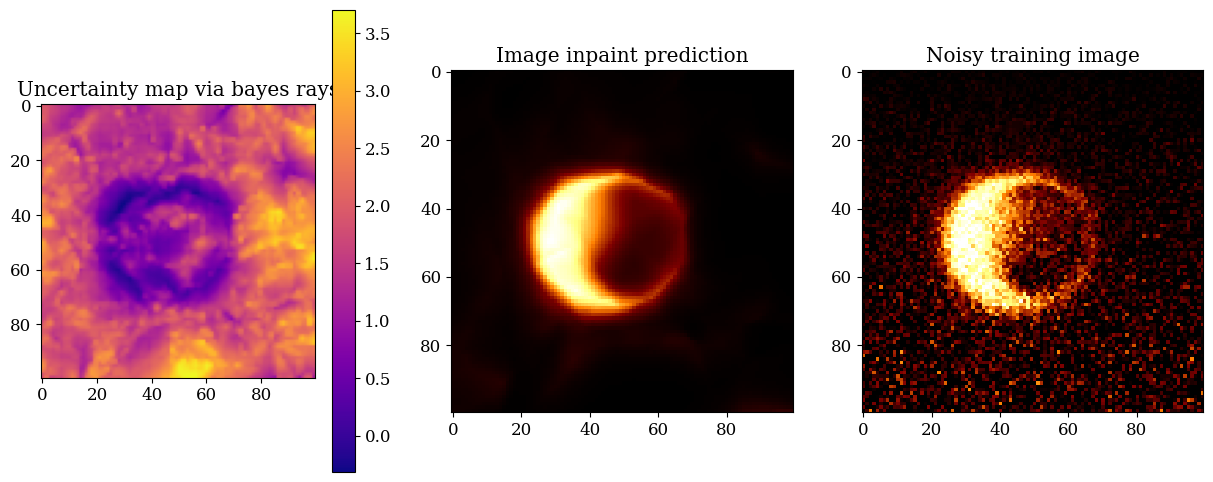

In [42]:
chunk_size = 32
J_sq = fisher_sum_hetero(chunk_size, grid_res)

lam = 1e-4 / (grid_res[0]*grid_res[1])
H_diag = (4/coords_flat.shape[0])*(J_sq) + 2.0 * lam # deterministic H, no monte carlo
variance_grid = 1 / H_diag
sigma_map = jnp.linalg.norm(
    jnp.sqrt(bilinear(coords, variance_grid)), 
    axis=-1
)

full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)


fig, ax = plt.subplots(1, 3, figsize=(15,6))
im_0 = ax[0].imshow(jnp.log10(sigma_map + 1e-12), cmap='plasma', origin="upper")
ax[0].set_title("Uncertainty map via bayes rays")
im_1 = ax[1].imshow(full_image, cmap='afmhot', origin='upper')
ax[1].set_title('Image inpaint prediction')
im_2 = ax[2].imshow(Y_train.reshape(ydim, xdim), vmin=vmin, vmax=vmax, cmap='afmhot', origin='upper')
ax[2].set_title('Noisy training image')
plt.tight_layout
fig.colorbar(im_0, ax=ax[0])